In [0]:
# import libraries
from pyspark.sql.window import Window 
from pyspark.sql.functions import lag, month, ceil, concat, year, lit, substring, quarter, year, round, mean
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### 1. Reference

#### 1.1 Period Types

In [0]:
%sql use snlcorp;
select PERIODTYPENAME,PERIODTYPEID
from snlperiodType
order by PERIODTYPENAME asc

PERIODTYPENAME,PERIODTYPEID
Annual,1
LTM,4
Monthly,5
Quarterly,2
Semi-annual,10
YTD,3


#### 1.2 Look up keyfields

In [0]:
%sql use snlCorp;
select *
from snlDataItem i
join snlDataItemDisplay d on d.DATAITEMID = i.DATAITEMID
--where i.DATAITEMDEFINITION LIKE '%securities%'
--where i.DATAITEMNAME like '%Securities%'
and d.PERSPECTIVE = 'Regulated Depositories (U.S.)'
and d.CATEGORY = 'Bank Reg Financials Summary'
where i.DATAITEMID in (215825,215363,215736)
limit 100;

DATAITEMID,DATAITEMNAME,DATAITEMDEFINITION,MAGNITUDE,DATACOLLECTIONTYPEID,ISTEXT,NMRANGEHIGH,NMRANGELOW,KPQI,SNLINDUSTRYID,DATAITEMID,PERSPECTIVE,CATEGORY,SUBCATEGORY,CATEGORYORDER,SUBCATEGORYORDER,DATAITEMORDER
215736,Total Securities,"Total book value of all securities. Includes U.S. Treasury securities, U.S. government agency and corporation obligations, securities issued by states and political subdivisions in the U.S., mortgaged-backed securities, other U.S. and non-U.S. debt securities, and all equity securities.",$000,1,0,null,null,205724,2,215736,Regulated Depositories (U.S.),Bank Reg Financials Summary,Summary Balance Sheet,15000,18000,18002
215736,Total Securities,"Total book value of all securities. Includes U.S. Treasury securities, U.S. government agency and corporation obligations, securities issued by states and political subdivisions in the U.S., mortgaged-backed securities, other U.S. and non-U.S. debt securities, and all equity securities.",$000,1,0,null,null,205724,3,215736,Regulated Depositories (U.S.),Bank Reg Financials Summary,Summary Balance Sheet,15000,18000,18002
215736,Total Securities,"Total book value of all securities. Includes U.S. Treasury securities, U.S. government agency and corporation obligations, securities issued by states and political subdivisions in the U.S., mortgaged-backed securities, other U.S. and non-U.S. debt securities, and all equity securities.",$000,1,0,null,null,205724,4,215736,Regulated Depositories (U.S.),Bank Reg Financials Summary,Summary Balance Sheet,15000,18000,18002
215825,Total Loans & Leases (Incl HFI & HFS),"Total of loans and lease financing receivables, held for investment & held for sale. Includes loans secured by real estate; loans to depository institutions; loans to finance agricultural production and other loans to farmers; commercial and industrial loans; acceptances of other banks (both U.S. and Non U.S.); loans to individuals for household, family, and other personal expenditures; loans to Non U.S. governments and official institutions; obligations of states and political subdivisions in the U.S.; other loans (e.g., for purchasing or carrying securities, and not including consumer loans); lease financing receivables (held for investment & held for sale); and less any unearned income on loans reflected in items above. Consolidated Banks only (Call Report Line Item: RCFD2122/RCON2122/RCON2122)",$000,1,0,null,null,205655,2,215825,Regulated Depositories (U.S.),Bank Reg Financials Summary,Financial Highlights,15000,16000,16003
215825,Total Loans & Leases (Incl HFI & HFS),"Total of loans and lease financing receivables, held for investment & held for sale. Includes loans secured by real estate; loans to depository institutions; loans to finance agricultural production and other loans to farmers; commercial and industrial loans; acceptances of other banks (both U.S. and Non U.S.); loans to individuals for household, family, and other personal expenditures; loans to Non U.S. governments and official institutions; obligations of states and political subdivisions in the U.S.; other loans (e.g., for purchasing or carrying securities, and not including consumer loans); lease financing receivables (held for investment & held for sale); and less any unearned income on loans reflected in items above. Consolidated Banks only (Call Report Line Item: RCFD2122/RCON2122/RCON2122)",$000,1,0,null,null,205655,3,215825,Regulated Depositories (U.S.),Bank Reg Financials Summary,Financial Highlights,15000,16000,16003
215825,Total Loans & Leases (Incl HFI & HFS),"Total of loans and lease financing receivables, held for investment & held for sale. Includes loans secured by real estate; loans to depository institutions; loans to finance agricultural production and other loans to farmers; commercial and industrial loans; acceptances of other banks (both U.S. and Non U.S.); loans to individuals for household, family, and other personal expenditures; loans to Non U.S. governments and o

### 2. Utility functions

#### 2.1 Create lookup for data items (keyfields)

In [0]:
%sql use snlbankregulatory;
create or replace temporary view fieldLookup as (
  select distinct dataitemid,'snlregflowperioddata' as tablename
  from snlregflowperioddata
  union
  select distinct dataitemid,'snlregflowperiodtextdata'
  from snlregflowperiodtextdata
  union 
  select distinct dataitemid,'snlregstockperioddata'
  from snlregstockperioddata
  union
  select distinct dataitemid,'snlregstockperiodtextdata'
  from snlregstockperiodtextdata
  union
  select distinct dataitemid,'snlcorpdata'
  from snlcorp.snlcorpdata
  union
  select distinct dataitemid,'snlcorptextdata'
  from snlcorp.snlcorptextdata
);

#### 2.2 Functions for getting data

In [0]:
def get_data(keyfield,keyinstn,start_date,end_date,period_type):

  # select database
  spark.sql(f"""use snlbankregulatory;""")

  # find table
  table_name = spark.sql(f"""
    select tablename
    from fieldLookup
    where dataitemid = {keyfield}
  """).collect()[0][0]
  
  if table_name == 'snlregflowperioddata':
    join_table1 = 'tn.REGFLOWPERIODID'
    join_table2 = 'fp.REGFLOWPERIODID'
  else:
    join_table1 = 'tn.REGSTOCKPERIODID'
    join_table2 = 'sp.REGSTOCKPERIODID'

  data = spark.sql(f"""
    select e.INSTITUTIONID,tn.DATAITEMID,i.DATAITEMNAME,sp.PERIODENDDATE,tn.DATAITEMVALUE
    from snlRegEntity e
    join snlRegStockPeriod sp on sp.INSTITUTIONID = e.INSTITUTIONID
    join snlRegFlowPeriod fp on fp.REGSTOCKPERIODID = sp.REGSTOCKPERIODID
    join {table_name} tn on {join_table1} = {join_table2}
    join snlCorp.snlDataItem i on i.DATAITEMID = tn.DATAITEMID
    where e.INSTITUTIONID = {keyinstn}
    and sp.ISCURRENT = 1
    and sp.PERIODENDDATE BETWEEN '{start_date}' and '{end_date}'
    and fp.PERIODTYPEID = {period_type}
    and tn.DATAITEMID = {keyfield}
    order by sp.PERIODENDDATE asc
  """)

  return data

In [0]:
def get_effr_monthly(start_date,end_date):

  '''returns the average monthly effective Federal funds rate for a given period.''' 

  # select database
  spark.sql(f"""use economicdata;""")

  data = spark.sql(f"""
    select p.TIMESERIESID,p.ASOF,p.VALUE as avg_effr_pct
    from ecrobservationproduct p
    where p.TIMESERIESID = '014585329'
    and p.PRODUCTNUMBER = '2000031815'
    and p.ASOF between '{start_date}' and '{end_date}'
    order by p.ASOF asc
  """)

  return data

#### 2.3 Function for calculating percentage changes

In [0]:
def get_percentage_changes(df,col_name):
  end_date = Window.orderBy("PERIODENDDATE")
  df = df.withColumn("prior_value",lag(df[col_name],1).over(end_date))
  df = df.withColumn("percentage_change",((df[col_name] / df["prior_value"])-1)*100)
  df = df.drop("prior_value")
  return df

#### 2.4 Function for adding quarterly labels

In [0]:
def add_quarter_labels(df,field_name):
  df = df.withColumn("Quarter",concat(lit("Q"),quarter(field_name),lit("'"),substring(year(df[field_name]),3,2))).orderBy(df[field_name].asc())
  return df

#### 2.5 Function for decomposing a time series and plotting it

In [0]:
def plot_add_decomp(df):
  col_name = df.select("DATAITEMNAME").collect()[0][0]
  df = df.withColumn("DATAITEMVALUE",df.DATAITEMVALUE.cast("float")).withColumnRenamed("DATAITEMVALUE",col_name).withColumn("INSTITUTIONID",df.INSTITUTIONID.cast("int")).withColumn("DATAITEMID",df.DATAITEMID.cast("int"))
  df_pd = df.toPandas().set_index('PERIODENDDATE')
  df_add = seasonal_decompose(df_pd[col_name], model = 'additive', extrapolate_trend='freq')
  df_plot = df_add.plot(observed=True, seasonal=False, trend=True, resid=False, weights=False)
  df_plot.show()

### 3. Data and visualizations

#### 3.1 Uninsured deposits
Limited to U.S. commercial banks, savings banks and savings & loan associations

In [0]:
uninsured = get_data(207555,3100122,'2020-12-31','2023-12-31',2)
# add quarter labels
uninsured = add_quarter_labels(uninsured,"PERIODENDDATE")
# convert to trillions and rename column
uninsured = uninsured.withColumn("dataitemvalue",uninsured['dataitemvalue'] / 1000000000).withColumnRenamed("dataitemvalue","Uninsured Deposits ($T)")
uninsured = uninsured.select("Quarter","Uninsured Deposits ($T)")
display(uninsured)

Quarter,Uninsured Deposits ($T)
Q4'20,7.3651124450000000
Q1'21,7.6009221000000000
Q2'21,7.8516912730000000
Q3'21,8.0264800820000000
Q4'21,8.3835317690000000
Q1'22,8.3915404580000000
Q2'22,8.1251873320000000
Q3'22,7.9161507210000000
Q4'22,7.6539794040000000
Q1'23,7.0518428800000000


Databricks visualization. Run in Databricks to view.

#### 3.2 Total deposits  
Includes domestic and foreign deposits

In [0]:
total_deposits = get_data(206127,3100122,'2020-12-31','2023-12-31',2)
# add quarter labels
total_deposits = add_quarter_labels(total_deposits,"PERIODENDDATE")
# convert to trillions and rename column
total_deposits = total_deposits.withColumn("dataitemvalue",total_deposits['dataitemvalue'] / 1000000000).withColumnRenamed("dataitemvalue","Total Deposits ($T)")
total_deposits = total_deposits.select("Quarter","Total Deposits ($T)")
display(total_deposits)

Quarter,Total Deposits ($T)
Q4'20,17.8232715320000000
Q1'21,18.4587026280000000
Q2'21,18.7305718460000000
Q3'21,19.1666722220000000
Q4'21,19.7004400130000000
Q1'22,19.9318996750000000
Q2'22,19.5623846040000000
Q3'22,19.3567363540000000
Q4'22,19.2145469490000000
Q1'23,18.7424893500000000


Databricks visualization. Run in Databricks to view.

#### 3.3 Changes in loans, securities and cash

In [0]:
# pick start and end date
# start with prior quarter for QOQ calculations
start_date = '2014-12-31'
end_date = '2023-12-31'

# pick keyfields
keyfields = [215825,215363,215736]

# pick keyinstn
keyinstn = 3100122 # all U.S. commercial banks, savings banks and savings & loan associations

# pick period type
#period_type = 2 # quarterly
period_type = 1 # annual

# create initial dataframe using first keyfield
df1 = get_data(keyfields[0],keyinstn,start_date,end_date,period_type)
field_name1 = df1.select("DATAITEMNAME").collect()[0][0]
df1 = get_percentage_changes(df1,"DATAITEMVALUE").withColumnRenamed("percentage_change",field_name1)
# create percentage changes table
df1 = df1.filter(df1[field_name1].isNotNull()).select(df1.PERIODENDDATE,df1[field_name1])

# add additional fields
for i in range(1,len(keyfields)):
  df2 = get_data(keyfields[i],keyinstn,start_date,end_date,period_type)
  field_name2 = df2.select("DATAITEMNAME").collect()[0][0]
  df2 = get_percentage_changes(df2,"DATAITEMVALUE").withColumnRenamed("percentage_change",field_name2)
  df2 = df2.filter(df2[field_name2].isNotNull()).select(df2.PERIODENDDATE,df2[field_name2])
  df1 = df1.join(df2,['PERIODENDDATE'],'inner')

# convert periodenddate to quarters
#df_labels = add_quarter_labels(df1,"PERIODENDDATE")
#display(df_labels)

df_loans = df1
display(df_loans)

PERIODENDDATE,Total Loans & Leases (Incl HFI & HFS),Cash & Equivalents,Total Securities
2015-12-31T00:00:00.000+0000,6.399000,-6.889400,4.187300
2016-12-31T00:00:00.000+0000,5.267300,4.150000,6.148800
2017-12-31T00:00:00.000+0000,4.471700,6.154800,2.024000
2018-12-31T00:00:00.000+0000,4.432500,-1.301400,2.513400
2019-12-31T00:00:00.000+0000,3.607500,-3.712100,6.944300
2020-12-31T00:00:00.000+0000,3.284400,78.070800,28.394700
2021-12-31T00:00:00.000+0000,3.521800,4.711400,22.164900
2022-12-31T00:00:00.000+0000,8.718800,-22.566000,-5.787700
2023-12-31T00:00:00.000+0000,1.841200,7.683000,-7.629800


Databricks visualization. Run in Databricks to view.

#### 3.4 Focus on bank core funding

In [0]:
# pick start and end date
# start with prior quarter for QOQ calc
start_date = '2018-12-31'
end_date = '2023-12-31'

# pick keyfields
# 216107 = brokered, 206127 = total deposits, 216842 = total borrowings
keyfields = [216107,206127,216842]

# pick keyinstn
keyinstn = 3100122 # all U.S. commercial banks, savings banks and savings & loan associations

# pick period type
#period_type = 2 # quarterly
period_type = 1 # annual

# create initial dataframe using first keyfield
df1 = get_data(keyfields[0],keyinstn,start_date,end_date,period_type)
field_name1 = df1.select("DATAITEMNAME").collect()[0][0]
df1 = df1.withColumnRenamed("DATAITEMVALUE",field_name1).drop("DATAITEMNAME")

# add additional fields
for i in range(1,len(keyfields)):
  df2 = get_data(keyfields[i],keyinstn,start_date,end_date,period_type)
  field_name2 = df2.select("DATAITEMNAME").collect()[0][0]
  df2 = df2.withColumnRenamed("DATAITEMVALUE",field_name2).drop("DATAITEMNAME")
  df1 = df1.join(df2,['PERIODENDDATE','INSTITUTIONID'],'inner')

# calculate non-brokered deposits
df1 = df1.withColumn("non_brokered",df1[field_name2] - df1[field_name1])

# add percentages
field_name1_pct = "Change in " + field_name1 + "(%)"
df1 = get_percentage_changes(df1,"Brokered Deposits").withColumnRenamed("percentage_change",field_name1_pct)
field_name2_pct = "Change in non-brokered deposits (%)"
df1 = get_percentage_changes(df1,"non_brokered").withColumnRenamed("percentage_change",field_name2_pct)
field_name3_pct = "Change in total borrowings (%)"
df1 = get_percentage_changes(df1,"Total Borrowings").withColumnRenamed("percentage_change",field_name3_pct)

df1 = df1.filter(df1[field_name1_pct].isNotNull())
df1 = df1.filter(df1[field_name2_pct].isNotNull())
df1 = df1.filter(df1[field_name3_pct].isNotNull())

#df_final = add_quarter_labels(df1,"PERIODENDDATE").select("Quarter",field_name1_pct,field_name2_pct,field_name3_pct)
df_final = df1.select("PERIODENDDATE",field_name1_pct,field_name2_pct,field_name3_pct)
display(df_final)

PERIODENDDATE,Change in Brokered Deposits(%),Change in non-brokered deposits (%),Change in total borrowings (%)
2019-12-31T00:00:00.000+0000,2.945000,-21.500600,-5.803900
2020-12-31T00:00:00.000+0000,2.821100,-57.883500,-15.284400
2021-12-31T00:00:00.000+0000,-46.988900,180.969700,-13.187700
2022-12-31T00:00:00.000+0000,48.276200,29.357700,39.197100
2023-12-31T00:00:00.000+0000,50.714200,-17.643100,20.228100


Databricks visualization. Run in Databricks to view.

### Time series decomposition  

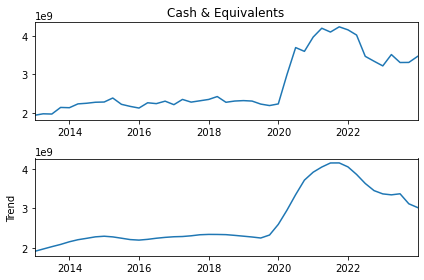

In [0]:
cash = get_data(215363,3100122,'2012-12-31','2023-12-31',2)
plot_add_decomp(cash)

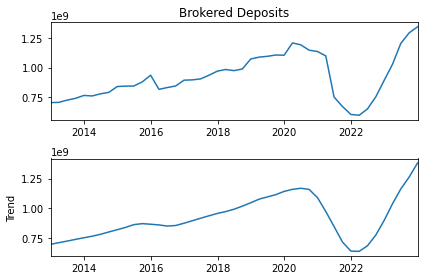

In [0]:
brokered = get_data(216107,3100122,'2012-12-31','2023-12-31',2)
plot_add_decomp(brokered)

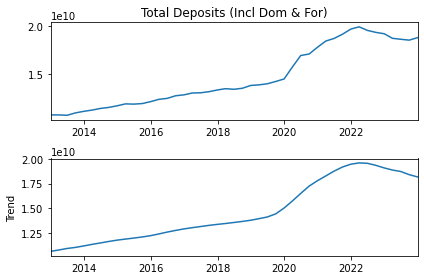

In [0]:
dep = get_data(206127,3100122,'2012-12-31','2023-12-31',2)
plot_add_decomp(dep)

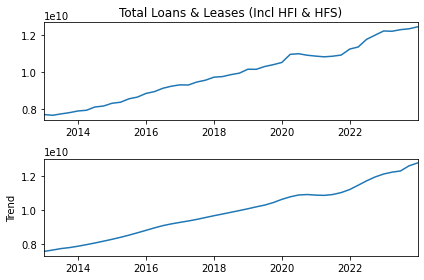

In [0]:
loans = get_data(215825,3100122,'2012-12-31','2023-12-31',2)
plot_add_decomp(loans)

In [0]:
afs_treas = get_data(206368,3100122,'2012-12-31','2023-12-31',2)
display(afs_treas)

INSTITUTIONID,DATAITEMID,DATAITEMNAME,PERIODENDDATE,DATAITEMVALUE
3100122,206368,AFS(C):US Treasury Secs,2012-12-31T00:00:00.000+0000,191970693.0000000000000000
3100122,206368,AFS(C):US Treasury Secs,2013-03-31T00:00:00.000+0000,174546523.0000000000000000
3100122,206368,AFS(C):US Treasury Secs,2013-06-30T00:00:00.000+0000,152646134.0000000000000000
3100122,206368,AFS(C):US Treasury Secs,2013-09-30T00:00:00.000+0000,146567225.0000000000000000
3100122,206368,AFS(C):US Treasury Secs,2013-12-31T00:00:00.000+0000,180585594.0000000000000000
3100122,206368,AFS(C):US Treasury Secs,2014-03-31T00:00:00.000+0000,216886922.0000000000000000
3100122,206368,AFS(C):US Treasury Secs,2014-06-30T00:00:00.000+0000,239884615.0000000000000000
3100122,206368,AFS(C):US Treasury Secs,2014-09-30T00:00:00.000+0000,299992446.0000000000000000
3100122,206368,AFS(C):US Treasury Secs,2014-12-31T00:00:00.000+0000,346083780.0000000000000000
3100122,206368,AFS(C):US Treasury Secs,2015-03-31T00:00:00.000+0000,337576359.0000000000000000


### Liquidity ratios  
Liquidity Ratio: (Cash&Balances Due+Securities+Fed Funds Sold&Repos+Trading Account Assets-Pledged Securities)/ Total Liabilities

In [0]:
lr = get_data(215608,3100122,'2012-12-31','2023-12-31',2)
# pre-pandemic average
ppa_avg = lr.sort("PERIODENDDATE").filter(lr.PERIODENDDATE < '2020-03-31').agg({"DATAITEMVALUE":"avg"}).collect()[0][0]
lr = lr.withColumn("pre_pandemic_avg",lit(ppa_avg))
display(lr)

INSTITUTIONID,DATAITEMID,DATAITEMNAME,PERIODENDDATE,DATAITEMVALUE,pre_pandemic_avg
3100122,215608,Liquidity Ratio,2012-12-31T00:00:00.000+0000,34.9300000000000000,35.47310344827586210000
3100122,215608,Liquidity Ratio,2018-09-30T00:00:00.000+0000,35.4200000000000000,35.47310344827586210000
3100122,215608,Liquidity Ratio,2022-06-30T00:00:00.000+0000,41.1300000000000000,35.47310344827586210000
3100122,215608,Liquidity Ratio,2022-09-30T00:00:00.000+0000,39.5100000000000000,35.47310344827586210000
3100122,215608,Liquidity Ratio,2015-09-30T00:00:00.000+0000,34.8300000000000000,35.47310344827586210000
3100122,215608,Liquidity Ratio,2020-12-31T00:00:00.000+0000,43.0500000000000000,35.47310344827586210000
3100122,215608,Liquidity Ratio,2021-03-31T00:00:00.000+0000,44.5700000000000000,35.47310344827586210000
3100122,215608,Liquidity Ratio,2023-06-30T00:00:00.000+0000,34.0100000000000000,35.47310344827586210000
3100122,215608,Liquidity Ratio,2023-09-30T00:00:00.000+0000,33.7100000000000000,35.47310344827586210000
3100122,215608,Liquidity Ratio,2013-09-30T00:00:00.000+0000,35.2600000000000000,35.47310344827586210000


Databricks visualization. Run in Databricks to view.

### Deconstructing the liquidity ratio  
Liquidity Ratio: (Cash&Balances Due+Securities+Fed Funds Sold&Repos+Trading Account Assets-Pledged Securities)/ Total Liabilities 

In [0]:
# liquid assets
# Total Cash & Bals Due Dep Inst, 215361
total_cash = get_data(215361,3100122,'2012-12-31','2023-12-31',2)
plot_add_decomp(total_cash)

In [0]:
# securities, 215736
total_sec = get_data(215736,3100122,'2012-12-31','2023-12-31',2)
plot_add_decomp(total_sec)

In [0]:
#Tot Fed Funds & Reverse Repos	215362
fed_funds = get_data(215362,3100122,'2012-12-31','2023-12-31',2)
plot_add_decomp(fed_funds)

In [0]:
# total trading assets, 215374
trading_acct_assets = get_data(215374,3100122,'2012-12-31','2023-12-31',2)
plot_add_decomp(trading_acct_assets)

In [0]:
%sql use snldepositoryrates;
select *
from 

### Gap between Fed Funds rate and cost of deposits  

In [0]:
start_date = '2016-01-01'
end_date = '2023-12-31'

In [0]:
# Calculate average effective Fed Funds rate by quarter
effr = get_effr_monthly(start_date,end_date)
# add quarter and year columns
effr = effr.withColumn("Quarter",quarter('ASOF'))
effr = effr.withColumn("Year",year('ASOF'))
# get average by quarter
effr = effr.groupBy(['Quarter','Year']).agg({'avg_effr_pct': 'mean'}).orderBy(["Year","Quarter"]).withColumnRenamed("avg(avg_effr_pct)","avg_fed_funds")
effr = effr.withColumn("Quarter",concat(lit("Q"),"Quarter",lit("'"),substring("Year",3,2))).select("Quarter",round("avg_fed_funds",2))
# interest expense
ie = get_data(215412,3100122,start_date,end_date,2)
field_name1 = ie.select("DATAITEMNAME").collect()[0][0]
ie = ie.withColumnRenamed("DATAITEMVALUE",field_name1).drop("DATAITEMNAME").sort("PERIODENDDATE")
# total deposits
td_start = str(int(start_date[:4]) - 1) + "-" + end_date[5:]
td = get_data(206127,3100122,td_start,end_date,2)
# add lag column to compute averages
end_date = Window.orderBy("PERIODENDDATE")
td = td.withColumn("prior_value",lag(td["DATAITEMVALUE"],1).over(end_date))
td = td.withColumn("avg_deposits",(td["DATAITEMVALUE"] + td["prior_value"]) / 2)
td = td.filter(td["avg_deposits"].isNotNull()).select(td.PERIODENDDATE,td.avg_deposits)
combo = td.join(ie,["PERIODENDDATE"],'inner')
# annualize interest expense and divide by average deposits
combo = combo.withColumn("cost_of_deposits",((combo["Int Exp: Total Deposits"] * 4) / combo.avg_deposits) * 100).select("PERIODENDDATE","cost_of_deposits").sort("PERIODENDDATE")
combo_q = add_quarter_labels(combo,'PERIODENDDATE')
combo_q = combo_q.join(effr,['Quarter'],'inner').withColumnRenamed("round(avg_fed_funds, 2)","avg_fed_funds")
combo_q = combo_q.withColumn("gap",combo_q.avg_fed_funds - combo_q.cost_of_deposits)
combo_q = combo_q.sort("PERIODENDDATE").select("Quarter","gap","cost_of_deposits","avg_fed_funds")
display(combo_q)

In [0]:
#https://builtin.com/data-science/time-series-python
#sns.lineplot(cash_pd.index,cash_pd['Cash and equivalents ($T)'])
#https://www.kaggle.com/code/chanakyavivekkapoor/decomposing-time-series-data  
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
# 014585329 matches FRED's https://fred.stlouisfed.org/series/FEDFUNDS
# average the monthly values to get other periods, like quarterly
# Comparison
#https://www.capitaliq.spglobal.com/apisv3/spg-webplatform-core/news/article?id=78295219
#https://www.capitaliq.spglobal.com/apisv3/spg-webplatform-core/news/article?id=79704760
# HVCRE
#https://www.capitaliq.spglobal.com/apisv3/spg-webplatform-core/news/article?id=80614340&KeyProductLinkType=58&redirected=1
#215464 is cost of interest-bearing deposits, but it doesn't use average deposits

Liquidity coverage:    
246762 Liquidity Coverage Ratio  
260757 High Quality Liquid Assets  
260758 Net Cash Outflows  
260799 Liquidity Coverage Ratio, As Reported  

### 4. Keyfield definitions

[KeyField:207555, UNINSURED_DEP_BKS_EST]  
RCON5597 (002), RCON5597 (031), RCON5597 (041), RCON5597 (051)  
The estimated value of the bank's deposits (in domestic offices and in insured branches in Puerto Rico and U.S. territories and possessions) that is not covered by federal deposit insurance.(Call Report Line Item: RCON5597)

[KeyField:215825, TOTAL_LOAN_LEASES_INCL_HFS]  
RCFD2122 (002), RCFD2122 (031), RCON2122 (041), RCON2122 (051), Acct_RB0079 (5300), BHCK2122 (Y9C)  
Total of loans and lease financing receivables, held for investment & held for sale. Includes loans secured by real estate; loans to depository institutions; loans to finance agricultural production and other loans to farmers; commercial and industrial loans; acceptances of other banks (both U.S. and Non U.S.); loans to individuals for household, family, and other personal expenditures; loans to Non U.S. governments and official institutions; obligations of states and political subdivisions in the U.S.; other loans (e.g., for purchasing or carrying securities, and not including consumer loans); lease financing receivables (held for investment & held for sale); and less any unearned income on loans reflected in items above. Consolidated Banks only (Call Report Line Item: RCFD2122/RCON2122/RCON2122)  
[Common Reg Financials] / [Loans and Leases] / [Total Loans & Leases (Incl HFI & HFS)]  

[KeyField:215363, REG_CASH_EQUIV]  
Total balances due from depository institutions; plus fed funds sold and securities purchased under agreements to resell  
[Common Reg Financials] / [Balance Sheet] / [Cash & Equivalents]  

[KeyField:215736, REG_TOTAL_SECS]  
Total book value of all securities. Includes U.S. Treasury securities, U.S. government agency and corporation obligations, securities issued by states and political subdivisions in the U.S., mortgaged-backed securities, other U.S. and non-U.S. debt securities, and all equity securities.  
[Bank Reg Financials Summary] / [Summary Balance Sheet] / [Total Securities]  

[KeyField:216842, TOTAL_BORROW]
Fed Funds Purchased and Repurchase Agreements + Advances from FHLB (where applicable) + Commercial Paper (where applicable) + Total Subordinated Debt and Mandatory Convertible Securities + Trading liabilities + Other Borrowings
[Bank Reg Financials Summary] / [Miscellaneous Data] / [Total Borrowings]  

[KeyField:215825, TOTAL_LOAN_LEASES_INCL_HFS]
RCFD2122 (002), RCFD2122 (031), RCON2122 (041), RCON2122 (051), Acct_RB0079 (5300), BHCK2122 (Y9C)
Total of loans and lease financing receivables, held for investment & held for sale. Includes loans secured by real estate; loans to depository institutions; loans to finance agricultural production and other loans to farmers; commercial and industrial loans; acceptances of other banks (both U.S. and Non U.S.); loans to individuals for household, family, and other personal expenditures; loans to Non U.S. governments and official institutions; obligations of states and political subdivisions in the U.S.; other loans (e.g., for purchasing or carrying securities, and not including consumer loans); lease financing receivables (held for investment & held for sale); and less any unearned income on loans reflected in items above. Consolidated Banks only (Call Report Line Item: RCFD2122/RCON2122/RCON2122)
[Bank Reg Financials Summary] / [Financial Highlights] / [Total Loans & Leases (Incl HFI & HFS)]  

[KeyField:215608, REG_LIQUIDITY_RATIO]
Liquidity Ratio: (Cash&Balances Due+Securities+Fed Funds Sold&Repos+Trading Account Assets-Pledged Securities)/ Total Liabilities
[Bank Reg Financials Summary] / [Financial Highlights] / [Liquidity Ratio]

Total assets: 206118  

### Footnotes  
Analysis includes operating and historical US commercial banks, savings banks, and savings and loan associations that reported estimated uninsured deposits in quarterly regulatory filings.  
Uninsured deposits are the bank's estimated value of deposits held in domestic US offices not covered by federal deposit insurance. Only banks with more than $1 billion in consolidated assets are required to report this field; however, some other institutions may also report.  
Data from call reports may include internal company deposits, collateralized deposits backed by pledged securities, as well as other deposits structured to qualify for insurance or other collateralization, and may be higher, sometimes significantly so, from GAAP filings at the parent-company level.  
Total deposits are calculated as total deposit liabilities before exclusions minus total allowable exclusions as reported in Schedule RC-O in in call report filings at the subsidiary level.  
Data based on regulatory call report filings.  

OLD STUFF

In [0]:
  # convert keyinstns to lists of strings
  #if type(keyfields) == list:
    #keyfields = ",".join([str(kf) for kf in keyfields])
  #if type(keyinstns) ==  list:
    #keyinstns = ",".join([str(ki) for ki in keyinstns])

  #field_name = "Change in " + df.select("DATAITEMNAME").collect()[0][0] + "(%)"
  #df = df.withColumn(field_name,((df["DATAITEMVALUE"] / df["prior_value"])-1)*100)

In [0]:
df1 = get_percentage_changes(loans_df)
df1 = add_quarter_labels(df1).withColumnRenamed("percentage_change","Total Loans and Leases").drop("DATAITEMID","DATAITEMNAME","DATAITEMVALUE").filter(df1["percentage_change"].isNotNull())
df2 = get_percentage_changes(cash_df)
df2 = add_quarter_labels(df2).withColumnRenamed("percentage_change","Cash and Equivalents").drop("DATAITEMID","DATAITEMNAME","DATAITEMVALUE").filter(df2["percentage_change"].isNotNull())
df3 = get_percentage_changes(sec_df)
df3 = add_quarter_labels(df3).withColumnRenamed("percentage_change","Total Securities").drop("DATAITEMID","DATAITEMNAME","DATAITEMVALUE").filter(df3["percentage_change"].isNotNull())

combo_df = df1.join(df2,df1.PERIODENDDATE == df2.PERIODENDDATE,'inner').drop(df2.PERIODENDDATE,df2.quarter)
combo_df = combo_df.join(df3,combo_df.PERIODENDDATE == df3.PERIODENDDATE,'inner').drop(df3.PERIODENDDATE,df3.quarter).select("quarter","Total Loans and Leases","Total Securities","Cash and Equivalents")
display(combo_df)

In [0]:
#df1 = get_percentage_changes(df1).withColumnRenamed("percentage_change",field_name1)
# create percentage changes table
#df1 = df1.filter(df1[field_name1].isNotNull()).select(df1.PERIODENDDATE,df1[field_name1])

  #df2 = get_percentage_changes(df2).withColumnRenamed("percentage_change",field_name2)
  #df2 = df2.filter(df2[field_name2].isNotNull()).select(df2.PERIODENDDATE,df2[field_name2])

#def get_percentage_changes(df):
  #end_date = Window.orderBy("PERIODENDDATE")
  #df = df.withColumn("prior_value",lag(df['DATAITEMVALUE'],1).over(end_date))
  #df = df.withColumn("percentage_change",((df["DATAITEMVALUE"] / df["prior_value"])-1)*100)
  #df = df.drop("prior_value")
  #return df

# add quarter labels
  #df = df.withColumn("PERIODENDDATE",concat(lit("Q"),ceil(month(df['PERIODENDDATE']) / 3),lit("'"),substring(year(df['PERIODENDDATE']),3,2))).orderBy(df["PERIODENDDATE"].asc()).withColumnRenamed("PERIODENDDATE","Quarter")

  #df = df.withColumn(field_name,concat(lit("Q"),ceil(month(df[field_name]) / 3),lit("'"),substring(year(df[field_name]),3,2))).orderBy(df[field_name].asc()).withColumnRenamed(field_name,"Quarter")
  
  #df = df.withColumn("Quarter",concat(lit("Q"),ceil(month(df[field_name]) / 3),lit("'"),substring(year(df[field_name]),3,2))).orderBy(df[field_name].asc())

  # create initial dataframe using first keyfield
#field_name = lr.select("DATAITEMNAME").collect()[0][0]
#lr = lr.withColumnRenamed("DATAITEMVALUE",field_name).drop("DATAITEMNAME")
#display(lr)
#display(ppa)
#lr.count()

In [0]:
  sql1 = """
    select e.INSTITUTIONID,tn.DATAITEMID,i.DATAITEMNAME,sp.PERIODENDDATE,tn.DATAITEMVALUE
    from snlRegEntity e
    join snlRegStockPeriod sp on sp.INSTITUTIONID = e.INSTITUTIONID
    join snlRegFlowPeriod fp on fp.REGSTOCKPERIODID = sp.REGSTOCKPERIODID
    """
  
  #if table_name == 'snlregflowperioddata':
  sql2 = """join {table_name} tn on tn.REGFLOWPERIODID = fp.REGFLOWPERIODID"""
  #else:  
  #sql2 = """join {table_name} tn on tn.REGSTOCKPERIODID = sp.REGSTOCKPERIODID"""

  sql3 = """join snlCorp.snlDataItem i on i.DATAITEMID = tn.DATAITEMID
    where e.INSTITUTIONID = {keyinstn}
    and sp.ISCURRENT = 1
    and sp.PERIODENDDATE BETWEEN '{start_date}' and '{end_date}'
    and fp.PERIODTYPEID = {period_type}
    and tn.DATAITEMID = {keyfield}
    order by sp.PERIODENDDATE asc"""

  print(sql1 + sql2 + sql3)

In [0]:
def get_econ_ts(ts_id,start_date,end_date):

  # select database
  spark.sql(f"""use economicdata;""")

  data = spark.sql(f"""
    select p.TIMESERIESID,ts.SHORTLABEL,p.ASOF,p.VALUE
    from ecrobservationproduct p
    join ecrtimeseries ts on ts.TIMESERIESID = p.TIMESERIESID
    where p.TIMESERIESID = '{ts_id}'
    and p.PRODUCTNUMBER = '2000031815'
    and p.ASOF between '{start_date}' and '{end_date}'
    order by p.ASOF asc
  """)

  return data

In [0]:
latest_val = float(lr.filter(lr.PERIODENDDATE == '2023-12-31').select('DATAITEMVALUE').collect()[0][0])
comp = lr.filter(lr.PERIODENDDATE < '2020-03-31')
comp_mean = float(comp.agg({"DATAITEMVALUE":"avg"}).collect()[0][0])
comp_std = float(comp.agg({"DATAITEMVALUE":"std"}).collect()[0][0])
z_score = (latest_val - comp_mean) / comp_std
print(z_score)

In [0]:
def z_score(latest_data,comparison_data):

  latest_val = float(latest_data.select('DATAITEMVALUE').collect()[0][0])
  comp_mean = float(comparison_data.agg({"DATAITEMVALUE":"avg"}).collect()[0][0])
  comp_std = float(comparison_data.agg({"DATAITEMVALUE":"std"}).collect()[0][0])
  z_score = (latest_val - comp_mean) / comp_std
  
  return z_score

In [0]:
latest_data = get_data(215608,3100122,'2023-10-01','2023-12-31',2)
comparison_data = get_data(215608,3100122,'2012-12-31','2019-12-31',2)
z_score = z_score(latest_data,comparison_data)
print(z_score)

In [0]:
latest_data = get_data(215825,3100122,'2023-10-01','2023-12-31',2)
comparison_data = get_data(215825,3100122,'2012-12-31','2019-12-31',2)
#z = z_score(latest_data,comparison_data)
#print(z)
display(comparison_data)